In [6]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from feat import Detector

### とりま

In [7]:
from feat.plotting import imshow

def plot_image_and_aus(image_path, aus):
  """
画像と対応するアクションユニット（AU）の配列をプロットする関数。
:param image_path: 画像のパス
:param aus: アクションユニットの配列
"""
  image = cv2.imread(image_path)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title("Image")
  plt.axis("off")
  plt.subplot(1, 2, 2)
  plt.bar(range(len(aus)), list(aus.values()), tick_label=list(aus.keys()))
  plt.title("Action Units")
  plt.xlabel("AU")
  plt.ylabel("Intensity")
  plt.xticks(rotation=45)

  plt.tight_layout()
  plt.show()


def detect_features_from_image(image_path):
  #---

  face_model = "retinaface"
  landmark_model = "mobilefacenet" #"mobilefacenet"
  #landmark_model = "pfld"
  au_model = "svm"
  au_model='xgb'
  emotion_model = "resmasknet"
  facepose_model="img2pose"
  detector = Detector(
    face_model=face_model,
    landmark_model=landmark_model,
    au_model=au_model,
    emotion_model=emotion_model,
    facepose_model=facepose_model
  )

  #detector

  imshow(image_path)

  #---
  image = cv2.imread(image_path)
  detected_faces = detector.detect_faces(image)
  if not detected_faces:
    return "検出された顔なし"

  landmarks = detector.detect_landmarks(image, detected_faces)

  aus = []
  emotions = []
  for i, face in enumerate(detected_faces):
    au = detector.detect_aus(image, landmarks[i])
    emotion = detector.detect_emotions(image, face, landmarks[i])
    aus.append(au)
    emotions.append(emotion)

  return {
      "face": detected_faces,
      "landmarks": landmarks,
      "aus": aus,
      "emotions": emotions
  }

def get_aus_from_image(image_path):
  detector = Detector(face_model="retinaface", landmark_model="mobilenet", au_model="svm")
  image = cv2.imread(image_path)
  try:
    faces = detector.detect_faces(image)
    if not faces:
      return "No face detected"
    landmarks = detector.detect_landmarks(image, faces)
    aus = detector.detect_aus(image, landmarks)
    if aus:
      return aus[0]["aus"]
    else:
      return "No AU detected"
  except Exception as e:
    return str(e)

%%time

image_path = "./ForMachineLearning/20201127_1840_5_y/images/20201127_184657_040630.jpg"
print("-------------------")
features = detect_features_from_image(image_path)

aus = features["aus"]

print("-------------")
if aus and isinstance(aus[0], dict):
  plot_image_and_aus(image_path, aus[0])
else:
  print(aus)

### テスト

-------------------


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]
/home/buntin/jupyter-env/lib64/python3.9/site-packages/feat/data.py:618: DeprecationWarning: Fex.facebox has been renamed to Fex.faceboxes
  warnings.warn(
/home/buntin/jupyter-env/lib64/python3.9/site-packages/feat/data.py:507: DeprecationWarning: Fex.facepose has now been renamed to Fex.poses
  warnings.warn(


   FaceRectX   FaceRectY  FaceRectWidth  FaceRectHeight  FaceScore
0  257.60319  184.782085     122.305501      166.027668   0.999589
       AU01      AU02     AU04      AU05      AU06  AU07      AU09      AU10   
0  0.689043  0.247472  0.72394  0.337376  0.081798   0.0  0.107829  0.004956  \

   AU11      AU12      AU14      AU15      AU17  AU20      AU23      AU24   
0   1.0  0.023251  0.126088  0.249706  0.499708   0.0  0.517424  0.519205  \

       AU25      AU26      AU28      AU43  
0  0.016367  0.204337  0.576464  0.066803  
      anger   disgust      fear  happiness   sadness  surprise   neutral
0  0.004819  0.000023  0.000045   0.000496  0.185312  0.000119  0.809186
      Pitch      Roll       Yaw
0 -2.009436 -0.104213  5.045765
CPU times: user 8.22 s, sys: 1.07 s, total: 9.29 s
Wall time: 5.69 s


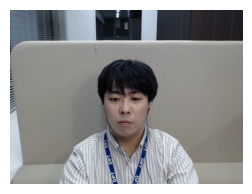

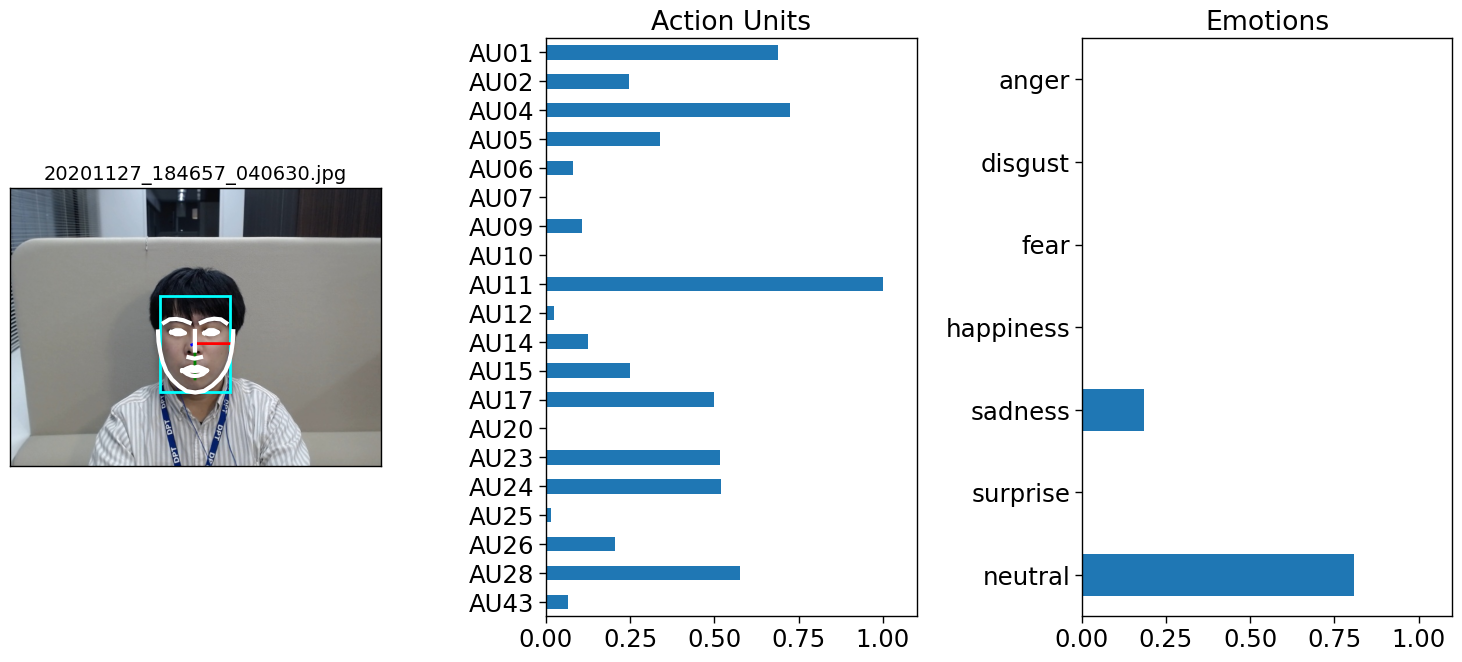

In [10]:
%%time

image_path = "./ForMachineLearning/20201127_1840_5_y/images/20201127_184657_040630.jpg"
print("-------------------")
#---

face_model = "retinaface"
landmark_model = "mobilefacenet" #"mobilefacenet"
#landmark_model = "pfld"
au_model = "svm"
au_model='xgb'
emotion_model = "resmasknet"
facepose_model="img2pose"

detector = Detector(
  face_model=face_model,
  landmark_model=landmark_model,
  au_model=au_model,
  emotion_model=emotion_model,
  facepose_model=facepose_model
)

imshow(image_path)
f = detector.detect_image(image_path)
print(f.facebox)
print(f.aus)
print(f.emotions)
print(f.facepose)

figs = f.plot_detections(poses=True)


In [9]:
%%time
image = cv2.imread(image_path)
detected_faces = detector.detect_faces(image)
if not detected_faces:
  return "検出された顔なし"

landmarks = detector.detect_landmarks(image, detected_faces)

aus = []
emotions = []
for i, face in enumerate(detected_faces):
  au = detector.detect_aus(image, landmarks[i])
  emotion = detector.detect_emotions(image, face, landmarks[i])
  aus.append(au)
  emotions.append(emotion)
print("-------------------")
print(features)

SyntaxError: 'return' outside function (<timed exec>, line 4)